In [1]:
# Detect if we are in Google Colaboratory
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

from pathlib import Path

if IN_COLAB:
    google.colab.drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd drive/My\ Drive/aerophoto/

/content/drive/My Drive/aerophoto


In [1]:
import pandas as pd 
import numpy as np
import glob
from tqdm import tqdm
import cv2
import os
from sklearn.model_selection import train_test_split, StratifiedKFold
import json
import random

import imgaug
import imgaug.augmenters as iaa

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import torchvision
from torchvision import datasets, transforms

from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
print(f"opencv version: {cv2.__version__}")
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")
print(f"imgaug version: {imgaug.__version__}")

opencv version: 4.1.2
torch version: 1.12.0+cu113
torchvision version: 0.13.0+cu113
imgaug version: 0.2.9


In [4]:
def set_seed(SEED):
    np.random.seed(SEED)
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True

RANDOM_STATE = 23
set_seed(RANDOM_STATE)

Ожидается, что данные уже были разархивированы и распределены по папкам следующим образом.


```
project
│   Solution.ipynb   
│
└───train
│   └───img
│       │   1.png
│       │   2.png
│       │   ...
│   └───json
│       │   1.json
│       │   2.json
│       │   ...
│   
└───test
    │   101.png
    │   102.png
    └───json
        |   <empty> <Here the test solution would be located>
```

## Add additional samples to dataset

In [ ]:
train_img = glob.glob("train/img/*.png")
train_json = glob.glob("train/json/*.json")
print(f"Train images: {len(train_img)}, train jsons: {len(train_json)}")

Train images: 800, train jsons: 800


In [ ]:
def get_rotated_rect(img, center, angle, rect_size):
    '''
    Rotate an image around point "center" by a given angle

    img - sourse image
    center - point on the image to rotate around
    angle - rotation angle
    rect_size - size of cropped patch

    Returns:
    patch - cropped patch rectangle
    pts_tf - rectangle vertices
    '''
    w, h, _ = img.shape
    w_rect, h_rect = rect_size
    x, y = center 
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    M_inv = cv2.getRotationMatrix2D(center, -angle, 1.0)

    image_rotated = cv2.warpAffine(img, M, (w,h))
    patch = image_rotated[y-h_rect//2:y+h_rect//2, x-w_rect//2:x+w_rect//2]

    x1_rot,y1_rot = (x-w_rect//2, y-h_rect//2)
    x2_rot,y2_rot = (x+w_rect//2, y-h_rect//2)
    x3_rot,y3_rot = (x+w_rect//2, y+h_rect//2)
    x4_rot,y4_rot = (x-w_rect//2, y+h_rect//2)
    pts = np.array([[x1_rot, y1_rot],
                    [x2_rot, y2_rot],
                    [x3_rot, y3_rot],
                    [x4_rot, y4_rot]])
    ones = np.ones(shape=(len(pts), 1))
    pts_ones = np.hstack([pts, ones])
    pts_tf = M_inv.dot(pts_ones.T).T.astype(int)
    pts_tf_dict = {"left_top":     [int(pts_tf[0,0]), int(pts_tf[0,1])],
                   "right_top":    [int(pts_tf[1,0]), int(pts_tf[1,1])],
                   "right_bottom": [int(pts_tf[2,0]), int(pts_tf[2,1])],
                   "left_bottom":  [int(pts_tf[3,0]), int(pts_tf[3,1])]}

    return patch, pts_tf, pts_tf_dict


def cut_random_patches_from_image(image, N_patches, patch_size, N_angle=1, save_path="train/"):
    """
    Given large image, crop N patches of given patch_size from it
    """
    h, w, _ = image.shape
    h_rect, w_rect = patch_size

    h0, w0 = int(h_rect/np.sqrt(2)) + 1, int(w_rect/np.sqrt(2)) + 1
    x_arr = np.random.randint(w0, w-w0, size=N_patches)
    y_arr = np.random.randint(h0, h-h0, size=N_patches)

    pts_arr = []
    for i in tqdm(range(N_patches)):
        center = (x_arr[i], y_arr[i])
        angle_arr = np.random.randint(0, 359, size=N_angle)
        for angle in angle_arr:
            patch, pts_tf, pts_tf_dict = get_rotated_rect(image, center, int(angle), patch_size)
            cv2.imwrite(save_path + f'img/aug_{i}_{angle}.png', patch)
            pts_tf_dict["angle"] = int(angle)
            with open(save_path + f'json/aug_{i}_{angle}.json', 'w') as fp:
                json.dump(pts_tf_dict, fp)
            pts_arr.append(pts_tf)
    return pts_arr

In [ ]:
# crop N_patches*N_angle additional images from the large one for train
set_seed(RANDOM_STATE)

img_name = 'original.tiff'
image = cv2.imread(img_name)

patch_size = (1024,1024)
N_patches = 3000
N_angle = 1

pts_arr = cut_random_patches_from_image(image, N_patches, patch_size, N_angle, save_path="train/")

100%|██████████| 3000/3000 [37:39<00:00,  1.33it/s]


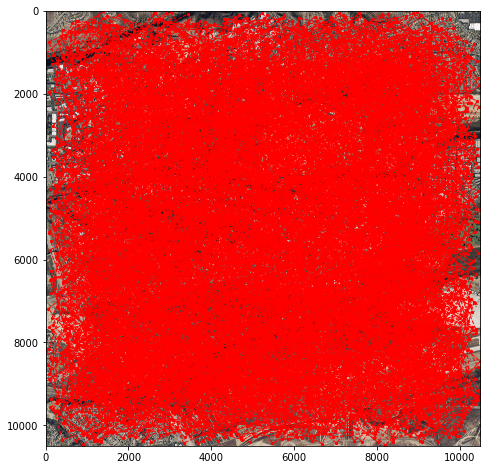

In [ ]:
# plot patches on a large image
image_plot = np.array(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.figure(figsize=(10,8))
plt.imshow(image_plot)

for pts in pts_arr:
    plt.scatter(pts[:,0], pts[:,1], color='red', s=5)
    plt.plot(pts[[0,1],0], pts[[0,1],1], '--', color='red', linewidth=1)
    plt.plot(pts[[1,2],0], pts[[1,2],1], '--', color='red', linewidth=1)
    plt.plot(pts[[2,3],0], pts[[2,3],1], '--', color='red', linewidth=1)
    plt.plot(pts[[3,0],0], pts[[3,0],1], '--', color='red', linewidth=1)

plt.show()

In [ ]:
# After cropping additional images
train_img = glob.glob("train/img/*.png")
train_json = glob.glob("train/json/*.json")
print(f"Train images: {len(train_img)}, train jsons: {len(train_json)}")

Train images: 3800, train jsons: 3800


## Dataset

In [5]:
# read data into df
json_dir = "train/json/"
H_max = 10496
angle_max = 359

data_df = pd.DataFrame({'id': [],
                        'left_top_x': [],
                        'left_top_y': [],
                        'right_top_x': [],
                        'right_top_y': [],
                        'left_bottom_x': [],
                        'left_bottom_y': [],
                        'right_bottom_x': [],
                        'right_bottom_y': [],
                        'angle': []})

json_true = []
for _, _, files in os.walk(json_dir):
    for x in files:
        if x.endswith(".json"):
            data = json.load(open(json_dir + x))
            new_row = {'id':x.split(".")[0]+".png", 
                       'left_top_x': data["left_top"][0]/H_max, 
                       'left_top_y': data["left_top"][1]/H_max, 
                       'right_top_x': data["right_top"][0]/H_max,
                       'right_top_y': data["right_top"][1]/H_max,
                       'left_bottom_x': data["left_bottom"][0]/H_max, 
                       'left_bottom_y': data["left_bottom"][1]/H_max,
                       'right_bottom_x': data["right_bottom"][0]/H_max, 
                       'right_bottom_y': data["right_bottom"][1]/H_max,
                       'angle': data["angle"]/angle_max}
            data_df = data_df.append(new_row, ignore_index=True)

In [6]:
# center data and make sure that small aerial photos and large photo were taken
# at the same height (the distances are comparable)
labels = ["left_top_x",
          "left_top_y",
          "right_top_x",
          "right_top_y",
          "left_bottom_x",
          "left_bottom_y",
          "right_bottom_x",
          "right_bottom_y",
          "angle"]
data_df['center_x'] = (data_df['left_top_x'] + data_df['right_bottom_x']) / 2
data_df['center_y'] = (data_df['left_top_y'] + data_df['right_bottom_y']) / 2

data_df['dist'] = np.sqrt((data_df['left_top_x'] - data_df['right_bottom_x'])**2 + (data_df['left_top_y'] - data_df['right_bottom_y'])**2)
h = data_df['dist'].mean()*H_max / np.sqrt(2)
print(f"Size of dataset images: {int(h)}")

labels = ["left_top_x",
          "left_top_y",
          "right_top_x",
          "right_top_y",
          "left_bottom_x",
          "left_bottom_y",
          "right_bottom_x",
          "right_bottom_y",
          "angle",
          "center_x",
          "center_y"]

data_df[labels] = 2*data_df[labels] - 1

Size of dataset images: 1024


In [7]:
# additional labels for augmented images and train images with clouds
data_df["aug"] = np.zeros(data_df.shape[0], dtype=int)
data_df["cloud"] = np.zeros(data_df.shape[0], dtype=int)
for i in range(data_df.shape[0]):
    name = data_df.iloc[i]['id']
    if 'aug' in name:
        data_df["aug"][i] = 1
    elif int(name.split('.')[0]) > 800:
        data_df["cloud"][i] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [8]:
data_df.head()

,id,left_top_x,left_top_y,right_top_x,right_top_y,left_bottom_x,left_bottom_y,right_bottom_x,right_bottom_y,angle,center_x,center_y,dist,aug,cloud
0,aug_2000_132.png,-0.054306,0.476753,-0.185023,0.621761,-0.199314,0.346037,-0.330030,0.491044,-0.264624,-0.192168,0.483899,0.138047,1,0
1,aug_2001_103.png,-0.005526,-0.812119,-0.049543,-0.621951,-0.195694,-0.856136,-0.239710,-0.665968,-0.426184,-0.122618,-0.739043,0.138024,1,0
2,aug_2002_335.png,-0.381669,-0.565168,-0.204840,-0.647675,-0.299162,-0.388338,-0.122332,-0.470846,0.866295,-0.252001,-0.518007,0.137978,1,0
3,aug_2003_73.png,-0.102134,0.112614,-0.044970,0.299162,-0.288681,0.169779,-0.231517,0.356326,-0.593315,-0.166825,0.234470,0.137963,1,0
4,aug_2004_241.png,0.613567,0.274200,0.518864,0.103468,0.784299,0.179497,0.689596,0.008765,0.342618,0.651582,0.141482,0.138054,1,0


In [9]:
train_img = glob.glob("train/img/*.png")
count_cloud = 0
for f in train_img:
    if 'aug' not in f:
        if int(f.split('/')[-1].split('.')[0]) > 800:
            count_cloud += 1
print(800, count_cloud, f"| train % of images with clouds: {count_cloud / 800}")

test_img = glob.glob("test/*.png")
count_cloud = 0
for f in test_img:
    if 'aug' not in f:
        if int(f.split('/')[-1].split('.')[0]) > 800:
            count_cloud += 1
print(400, count_cloud, f"| test % of images with clouds: {count_cloud / 400}")

800 272 | train % of images with clouds: 0.34
400 128 | test % of images with clouds: 0.32


In [10]:
# define dataset with cloud augmentations
class ImageDataset_cloud(Dataset):
    def __init__(self, data_df, transform1=None, transform2=None,
                 img_path="train/img/", RANDOM_STATE=23, n_classes=5):

        self.data_df = data_df
        self.transform1 = transform1
        self.transform2 = transform2
        self.cloud = iaa.weather.Clouds(random_state=RANDOM_STATE)
        self.img_path = img_path
        self.n_classes = n_classes

    def __getitem__(self, idx):
        # image name and corresponding labels
        image_name = self.data_df.iloc[idx]['id']
        if self.n_classes == 3:
            labels = [self.data_df.iloc[idx]['center_x'], 
                      self.data_df.iloc[idx]['center_y'],
                      self.data_df.iloc[idx]['angle']]
        elif self.n_classes == 5:
            labels = [self.data_df.iloc[idx]['left_top_x'], 
                      self.data_df.iloc[idx]['left_top_y'],
                      self.data_df.iloc[idx]['right_bottom_x'],
                      self.data_df.iloc[idx]['right_bottom_y'],
                      self.data_df.iloc[idx]['angle']]
        elif self.n_classes == 9:
            labels = [self.data_df.iloc[idx]['left_top_x'], 
                      self.data_df.iloc[idx]['left_top_y'],
                      self.data_df.iloc[idx]['right_bottom_x'],
                      self.data_df.iloc[idx]['right_bottom_y'],
                      self.data_df.iloc[idx]['right_top_x'], 
                      self.data_df.iloc[idx]['right_top_y'],
                      self.data_df.iloc[idx]['left_bottom_x'], 
                      self.data_df.iloc[idx]['left_bottom_y'],
                      self.data_df.iloc[idx]['angle']]
        elif self.n_classes == 11:
            labels = [self.data_df.iloc[idx]['left_top_x'], 
                      self.data_df.iloc[idx]['left_top_y'],
                      self.data_df.iloc[idx]['right_bottom_x'],
                      self.data_df.iloc[idx]['right_bottom_y'],
                      self.data_df.iloc[idx]['right_top_x'], 
                      self.data_df.iloc[idx]['right_top_y'],
                      self.data_df.iloc[idx]['left_bottom_x'], 
                      self.data_df.iloc[idx]['left_bottom_y'],
                      self.data_df.iloc[idx]['center_x'],
                      self.data_df.iloc[idx]['center_y'],
                      self.data_df.iloc[idx]['angle']]

        # read the image
        f = f"{self.img_path}{image_name}"
        image = cv2.imread(f)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)

        # transform image before applying cloud augmentation
        image = self.transform1(image)

        # apply cloud augmentation
        p = np.random.random()
        if self.data_df.iloc[idx]['aug'] and p < 1/3:
            image = np.array(image)*255
            image = image.astype(np.uint8)
            image = self.cloud(images=[image])[0] / 255

        # apply second part of tranform
        image = self.transform2(image)
        
        return image.float(), torch.tensor(labels).float()
    
    def __len__(self):
        return len(self.data_df)

In [11]:
# define image transformations
size = 256

train_transform1 = transforms.Compose([
    transforms.Resize((size,size))])

train_transform2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])

valid_transform1 = transforms.Compose([
    transforms.Resize((size,size))])

valid_transform2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])

In [12]:
# split dataset into train/validation
train_df, valid_df = train_test_split(data_df, test_size=0.15,
                                      random_state=RANDOM_STATE, stratify=data_df['cloud'])

In [13]:
print(train_df.shape, valid_df.shape)

(3230, 15) (570, 15)


In [14]:
img_path = 'train/img/'
n_classes = 9

train_dataset = ImageDataset_cloud(train_df, train_transform1, train_transform2,
                                   img_path=img_path, RANDOM_STATE=RANDOM_STATE,
                                   n_classes=n_classes)
valid_dataset = ImageDataset_cloud(valid_df, valid_transform1, valid_transform2,
                                   img_path=img_path, RANDOM_STATE=RANDOM_STATE,
                                   n_classes=n_classes)

In [21]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=40,
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=2)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=40,
                                           # shuffle=True,
                                           pin_memory=True,
                                           num_workers=2)

## Train utilities

In [22]:
# define metric computation and train loop

def compute_metric(data_true, data_pred, outImageW = 10496, outImageH = 10496):
    x_center_true = int((data_true[0] + data_true[2])/2)
    y_center_true = int((data_true[1] + data_true[3])/2)

    x_metr = x_center_true - int((data_pred[0] + data_pred[2])/2)
    y_metr = y_center_true - int((data_pred[1] + data_pred[3])/2) 

    metr =  1 - 0.7 * (abs(x_metr)/outImageH + abs(y_metr)/outImageW)/2 - 0.3 * abs(data_true[-1] - data_pred[-1])/359
    return metr


def compute_metric_batch(predictions, labels):
    metr = 0
    for i in range(len(predictions)):
        pred = (predictions[i] + 1) / 2
        pred[:4] = np.rint(pred[:4]*10496).astype(int)
        pred[-1] = np.rint(pred[-1]*359).astype(int)
        
        label = (labels[i] + 1) / 2
        label[:4] = np.rint(label[:4]*10496).astype(int)
        label[-1] = np.rint(label[-1]*359).astype(int)
        metr += compute_metric(label, pred)
    return metr / len(predictions)


def train(model, criterion, optimizer, scheduler, train_loader, val_loader,
          N_EPOCHS=15, N_CLASSES=5, path='model.pth', device='cuda'):
    train_loss_log = []
    train_metric_log = []
    val_loss_log = []
    val_metric_log = []
    best_val_metric = 0.
    
    for epoch in range(N_EPOCHS):
        model.train()
        train_loss = []
        train_predictions = []
        train_labels = []

        for imgs, labels in tqdm(train_loader, desc=f"Epoch: {epoch}"):
            optimizer.zero_grad()

            imgs = imgs.to(device)
            labels = labels.to(device)

            y_pred = model(imgs)
            
            loss = criterion(y_pred, labels)
            loss.backward()
            
            train_loss.append(loss.item())
            train_predictions.extend(y_pred.detach().cpu().numpy())
            train_labels.extend(labels.detach().cpu().numpy())

            optimizer.step()

        train_metric = compute_metric_batch(train_predictions, train_labels)
        train_loss_log.extend(train_loss)
        train_metric_log.append(train_metric)
        print("Train loss: ", np.mean(train_loss))
        print("Train metric ", train_metric)
        
        if scheduler:
            scheduler.step()

        model.eval()

        val_loss = []
        val_predictions = []
        val_labels = []

        for imgs, labels in tqdm(val_loader, desc=f"Epoch: {epoch}"):
            with torch.no_grad():
                imgs = imgs.to(device)
                labels = labels.to(device)

                y_pred = model(imgs)

                loss = criterion(y_pred, labels)

                val_loss.append(loss.item())
                val_predictions.extend(y_pred.detach().cpu().numpy())
                val_labels.extend(labels.detach().cpu().numpy())
        
        val_metric = compute_metric_batch(val_predictions, val_labels)
        val_loss_log.extend(val_loss)
        val_metric_log.append(val_metric)
        print("Val loss: ", np.mean(val_loss))
        print("Val metric ", val_metric)

        if path is not None and val_metric > best_val_metric:
            best_val_metric = val_metric
            torch.save(model.state_dict(), path)

        clear_output()
        plot_history(train_loss_log, train_metric_log, val_loss_log, val_metric_log)

        torch.cuda.empty_cache()
        
    return train_loss_log, train_metric_log, val_loss_log, val_metric_log

In [23]:
def plot_history(train_loss, train_metric, val_loss, val_metric):
    fig, ax = plt.subplots(figsize=(14,8))
    plt.subplot(1,2,1)
    plt.plot(train_loss, label='train')
    plt.plot(np.arange(len(val_loss))*len(train_loss)/len(val_loss), val_loss, label='val')
    plt.xlabel('train steps', fontsize=18)
    plt.legend(loc='best', fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid()

    plt.subplot(1,2,2)
    plt.plot(train_metric, '.-', markersize=6, label='train')
    plt.plot(val_metric, '.-', markersize=6, label='val')
    plt.xlabel('epochs', fontsize=18)
    plt.legend(loc='best', fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid()

    plt.show()

In [24]:
# crossvalidation functions that I was unable to apply in many experiments due to
# the time limit in Colab
def create_model_ensemble(n_models, train_dataset, model_name, device='cuda', N_EPOCHS=10,
                          train_transform1=None, train_transform2=None,
                          val_transform1=None, val_transform2=None,
                          img_path='train/img/', n_classes=5):
    models = []
    
    for train_index, test_index in StratifiedKFold(n_splits=n_models).split(train_dataset, train_dataset["aug"]):
        if model_name == 'efficient_net_b4':
            model = torchvision.models.efficientnet_b4(pretrained=True)
            model.classifier[1] = nn.Linear(1792, 5)
        elif model_name == 'efficient_net_b2':
            model = torchvision.models.efficientnet_b2(pretrained=True)
            model.classifier[1] = nn.Linear(1408, 5)
        model.to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr=0.0004)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, N_EPOCHS, eta_min=1e-6)

        train_dataset_K = ImageDataset_cloud(train_dataset.iloc[train_index],
                                             train_transform1, train_transform2,
                                             img_path, n_classes=n_classes)
        train_loader_K = torch.utils.data.DataLoader(dataset=train_dataset_K,
                                                   batch_size=40,
                                                   shuffle=True,
                                                   pin_memory=True,
                                                   num_workers=2)
        
        fold_dataset_K = ImageDataset_cloud(train_dataset.iloc[test_index],
                                            val_transform1, val_transform2,
                                            img_path)
        fold_loader_K = torch.utils.data.DataLoader(dataset=fold_dataset_K,
                                                    batch_size=32,
                                                    shuffle=True,
                                                    pin_memory=True,
                                                    num_workers=2)
        
        models.append({
            "model": model,
            "optimizer": optimizer,
            "scheduler": scheduler,
            "train_loader": train_loader_K,
            "fold_loader": fold_loader_K
        })
    return models


def Kcrossvalid(n_models, model_name, criterion, train_dataset, val_dataset,
                train_transform1, train_transform2, val_transform1, val_transform2,
                N_EPOCHS=10, device='cuda', n_classes=5):
    models = create_model_ensemble(n_models, train_dataset, model_name, N_EPOCHS=N_EPOCHS,
                                   train_transform1=train_transform1, train_transform2=train_transform2,
                                   val_transform1=val_transform1, val_transform2=val_transform2,
                                   device=device, n_classes=n_classes)
    valid_dataset = ImageDataset_cloud(val_dataset, val_transform1, val_transform2,
                                       img_path=img_path, n_classes=n_classes)
    val_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                             batch_size=32,
                                             shuffle=True,
                                             pin_memory=True,
                                             num_workers=2)

    for epoch in range(N_EPOCHS):
        all_val_predictions = np.zeros((val_dataset.shape[0],5))
        all_val_labels = np.zeros((val_dataset.shape[0],5))

        for i in range(n_models):
            model = models[i]["model"]
            optimizer = models[i]["optimizer"]
            scheduler = models[i]["scheduler"]

            train_loader = models[i]["train_loader"]
            fold_loader = models[i]["fold_loader"]

            train_loss = []
            train_predictions = []
            train_labels = []

            for imgs, labels in tqdm(train_loader, desc=f"Epoch: {epoch}"):
                optimizer.zero_grad()

                imgs = imgs.to(device)
                labels = labels.to(device)

                y_pred = model(imgs)
                
                loss = criterion(y_pred, labels)
                loss.backward()
                
                train_loss.append(loss.item())
                train_predictions.extend(y_pred.detach().cpu().numpy())
                train_labels.extend(labels.detach().cpu().numpy())

                optimizer.step()

            print("Train loss: ", np.mean(train_loss))
            print("Train metric ", compute_metric_batch(train_predictions, train_labels))

            model.eval()

            fold_predictions = []
            fold_labels = []

            for imgs, labels in tqdm(fold_loader, desc=f"Epoch: {epoch}"):
                with torch.no_grad():
                    imgs = imgs.to(device)
                    labels = labels.to(device)

                    y_pred = model(imgs)

                    fold_predictions.extend(y_pred.detach().cpu().numpy())
                    fold_labels.extend(labels.detach().cpu().numpy())

            print("Fold metric: ", compute_metric_batch(fold_predictions, fold_labels))

            scheduler.step()

            model.eval()

            val_predictions = []
            val_labels = []

            for imgs, labels in tqdm(val_loader, desc=f"Epoch: {epoch}"):
                with torch.no_grad():
                    imgs = imgs.to(device)
                    labels = labels.to(device)

                    y_pred = model(imgs)

                    val_predictions.extend(y_pred.detach().cpu().numpy())
                    val_labels.extend(labels.detach().cpu().numpy())
            
            all_val_predictions += np.array(val_predictions)
            all_val_labels += np.array(val_labels)

            torch.cuda.empty_cache()
        
        all_val_predictions //= n_models
        all_val_labels //= n_models
        print("Val metric: ", compute_metric_batch(val_predictions, val_labels))
    return models

## Model

In [46]:
torch.cuda.empty_cache()
set_seed(RANDOM_STATE)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Create model
n_classes = 9
save_path = '3800_EN_b2_clouds_9cls_final.pth'

model = torchvision.models.efficientnet_b2(pretrained=True)
model.classifier[1] = nn.Linear(1408, n_classes)

model = model.to(device)
criterion = torch.nn.MSELoss()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [47]:
N_EPOCHS = 15

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, N_EPOCHS, eta_min=3e-6)

In [ ]:
train_loss_log, train_metric_log, val_loss_log, val_metric_log = train(model, 
                                                                    criterion, 
                                                                    optimizer,
                                                                    scheduler, 
                                                                    train_loader, 
                                                                    valid_loader, 
                                                                    N_EPOCHS=N_EPOCHS,
                                                                    N_CLASSES=n_classes,
                                                                    path=save_path,
                                                                    device=device)

## Check metric

In [43]:
def compute_metric(data_true, data_pred, outImageW = 10496, outImageH = 10496):
    x_center_true = int((data_true["left_top_x"] + data_true["right_bottom_x"])/2)
    y_center_true = int((data_true["left_top_y"] + data_true["right_bottom_y"])/2)

    x_metr = x_center_true - int((data_pred["left_top_x"] + data_pred["right_bottom_x"])/2)
    y_metr = y_center_true - int((data_pred["left_top_y"] + data_pred["right_bottom_y"])/2) 

    metr =  1 - 0.7 * (abs(x_metr)/outImageH + abs(y_metr)/outImageW)/2 - 0.3 * abs(data_true["angle"] - data_pred["angle"])/359
    return metr

def compute_metric_loader(model, loader):
    metric = 0
    n_samples = 0
    model.eval()
    for imgs, labels in tqdm(loader):
        imgs = imgs.to(device)
        
        labels = (labels + 1) / 2
        labels = labels.numpy()
        y_pred = model(imgs).detach().cpu().numpy()
        y_pred = (y_pred + 1) / 2
        for i in range(y_pred.shape[0]):
            n_samples += 1
            y_pred_labels = {"left_top_x": np.rint(y_pred[i][0]*10496).astype(int),
                            "left_top_y": np.rint(y_pred[i][1]*10496).astype(int),
                            "right_bottom_x": np.rint(y_pred[i][2]*10496).astype(int),
                            "right_bottom_y": np.rint(y_pred[i][3]*10496).astype(int),
                            "angle": np.rint(y_pred[i][-1]*359).astype(int)}
            labels_true = {"left_top_x": np.rint(labels[i][0]*10496).astype(int),
                        "left_top_y": np.rint(labels[i][1]*10496).astype(int),
                        "right_bottom_x": np.rint(labels[i][2]*10496).astype(int),
                        "right_bottom_y": np.rint(labels[i][3]*10496).astype(int),
                        "angle": np.rint(labels[i][-1]*359).astype(int)}
            metric += compute_metric(labels_true, y_pred_labels)
    return metric / n_samples

In [44]:
# compute final metrics for train/valid loaders
# it might slightly differ from train results due to random cloud augmentations in loaders
set_seed(RANDOM_STATE)

model = torchvision.models.efficientnet_b2(pretrained=True)
model.classifier[1] = nn.Linear(1408, n_classes)
model.load_state_dict(torch.load(save_path))
model = model.to(device)
model.eval()

metric_train = compute_metric_loader(model, train_loader)
metric_valid = compute_metric_loader(model, valid_loader)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 18/18 [04:05<00:00, 13.62s/it]


In [45]:
print(f"Train metric: {metric_train}")
print(f"Valid metric: {metric_valid}")

Train metric: 0.9781296775504859
Valid metric: 0.9632793349442489


## Make prediction for test

Make sure that there is folder _json_ in a folder with images.

```
└───test
    │   101.png
    │   102.png
    └───json
        |   <empty> <Here the test solution would be located>
```

In [37]:
!rm test/json/*.json

In [38]:
test_path = "test/"
test_imgs = glob.glob(test_path + "*.png")
for img_path in test_imgs:
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(image)
    transforms_arr = transforms.Compose([
                                 transforms.Resize((256,256)),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                      std=[0.229, 0.224, 0.225])
    ])
    image = transforms_arr(image)

    pred = model(image[None,:].to(device))
    pred = pred.detach().cpu().numpy()[0]
    pred = (pred + 1) / 2
    pred_dict = {"left_top": (int(np.rint(pred[0]*10496)), int(np.rint(pred[1]*10496))),
                 "right_bottom": (int(np.rint(pred[2]*10496)), int(np.rint(pred[3]*10496))),
                 "angle": int(np.rint(pred[-1]*359))}
    with open(test_path + f'json/{img_path.split("/")[-1].split(".")[0]}.json', 'w') as fp:
        json.dump(pred_dict, fp)

In [39]:
%cd test/json

/content/drive/MyDrive/aerophoto/test/json


In [40]:
!zip pred.zip *.json

updating: 1001.json (deflated 7%)
updating: 1002.json (deflated 7%)
updating: 1007.json (deflated 9%)
updating: 1010.json (deflated 9%)
updating: 1012.json (deflated 7%)
updating: 1013.json (deflated 7%)
updating: 1014.json (deflated 7%)
updating: 1017.json (deflated 9%)
updating: 1018.json (deflated 7%)
updating: 1021.json (deflated 9%)
updating: 1025.json (deflated 6%)
updating: 1031.json (deflated 9%)
updating: 1034.json (deflated 10%)
updating: 1037.json (deflated 9%)
updating: 1040.json (deflated 9%)
updating: 1041.json (deflated 9%)
updating: 1043.json (deflated 7%)
updating: 1047.json (deflated 7%)
updating: 1049.json (deflated 9%)
updating: 1057.json (deflated 7%)
updating: 105.json (deflated 6%)
updating: 1062.json (deflated 6%)
updating: 1063.json (deflated 9%)
updating: 1068.json (deflated 10%)
updating: 1070.json (deflated 7%)
updating: 1074.json (deflated 10%)
updating: 1077.json (deflated 9%)
updating: 107.json (deflated 7%)
updating: 1083.json (deflated 9%)
updating: 108

In [41]:
%cd ../../

/content/drive/MyDrive/aerophoto
